In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

import json

import sys
sys.path.append("../src")
from gait_gft import *


path_to_project = os.path.join('..')
misc_path = os.path.join(path_to_project, 'config')

with open(os.path.join(misc_path,'time_thresholds.json'), 'r') as f:
  time_thresholds = json.load(f)

with open(os.path.join(misc_path,'node_positions.json'), 'r') as f:
    pos_loaded = json.load(f)
    pos = {k: tuple(v) for k, v in pos_loaded.items()}

C:\Users\rdm42\Documents\GitHub\gft_gait_analysis\notebooks\../src\gait_gft.py:882: SyntaxWarning: invalid escape sequence '\h'
  title = f"$\hat{{V}}_{channel}$"
C:\Users\rdm42\Documents\GitHub\gft_gait_analysis\notebooks\../src\gait_gft.py:937: SyntaxWarning: invalid escape sequence '\h'
  title = f"$\hat{{V}}_{{{channel}}}$ - {pathology.title()}"


This repository contains the code developed for the analysis of human gait pathologies under the framework of **Graph Signal Processing (GSP)**.

The methods implemented here focus on modeling the human skeleton as a graph and applying **Graph Fourier Transform (GFT)** to study movement patterns and distinguish between normal and pathological gaits.  

Further details on the methodology and results can be found in my Master’s Thesis: [Graph Fourier Transform: A study of time-dependent graph signals](https://thesis.unipd.it/handle/20.500.12608/91831?mode=simple)

Data source: https://ieee-dataport.org/documents/azure-kinect-3d-skeleton-and-foot-pressure-data-pathological-gaits

# Graph Definition

Read edge list and define the graph model:

In [2]:
with open(os.path.join(misc_path, 'links.txt'),'r') as f:
    text = f.read()

nodes = [line.split('\t')[1] for line in text.split('\n')]
edges = [tuple(line.split('\t')[1:]) for line in text.split('\n')[1:]]

skeleton = GraphModel(edges, node_list=nodes)

Visualize the network's spectral structure:

C:\Users\rdm42\Documents\GitHub\gft_gait_analysis\notebooks\../src\gait_gft.py:359: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1], h_pad=1.5)


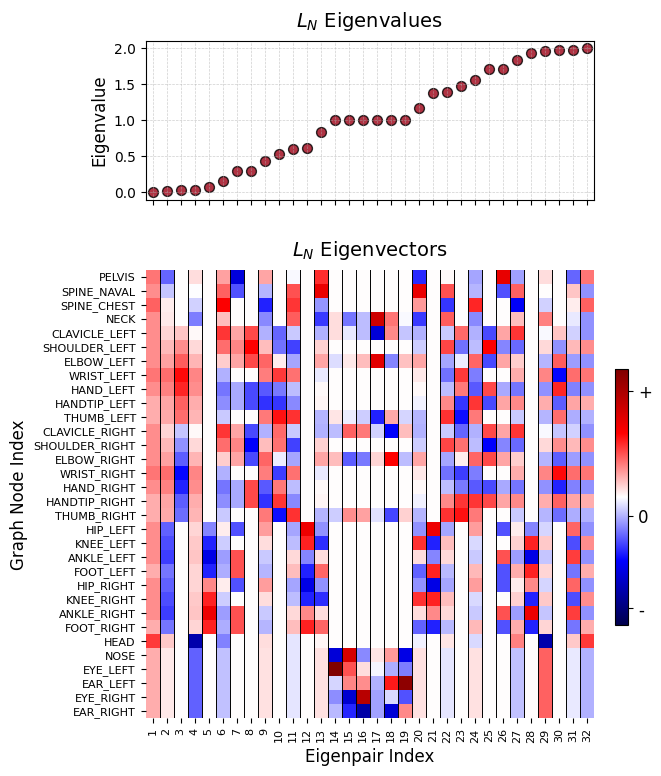

In [3]:
viz = Visualizer()
viz.plot_graph_basis(skeleton)

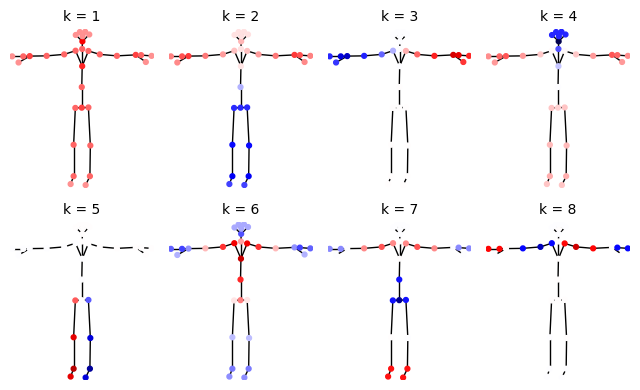

In [4]:
viz = Visualizer()
viz.plot_normal_modes_grid(skeleton, pos)

# Data Preprocessing

Read and preprocess signal data

In [5]:
path_to_zip = os.path.join(path_to_project, 'data', 'HDA_proj_A2.zip')
preproc = SkeletonPreprocessor(path_to_zip, nodes, time_thresholds)

r = preproc.load_and_process('subject1/normal/trial3/skeleton.csv')

r.head()

PELVIS                     SPINE_NAVAL            \
                                x         y         z           x         y   
2020-09-01 11:39:42.575  0.034774 -0.424728  0.867881    0.050272 -0.408131   
2020-09-01 11:39:42.605  0.039393 -0.419787  0.867807    0.055276 -0.403326   
2020-09-01 11:39:42.635  0.045329 -0.409982  0.868456    0.061105 -0.393985   
2020-09-01 11:39:42.665  0.046576 -0.406704  0.869113    0.062253 -0.390760   
2020-09-01 11:39:42.695  0.047960 -0.399230  0.869436    0.063882 -0.382442   

                                  SPINE_CHEST                          NECK  \
                                z           x         y         z         x   
2020-09-01 11:39:42.575  1.042860    0.061215 -0.406153  1.183480  0.080219   
2020-09-01 11:39:42.605  1.042762    0.066418 -0.401370  1.183369  0.085658   
2020-09-01 11:39:42.635  1.043570    0.072129 -0.393022  1.184279  0.090822   
2020-09-01 11:39:42.665  1.044304    0.073288 -0.389521  1.185061  0.091767   
2020-09-01 11:39:42.695  1.044568    0.075177 -0.379866  1.185318  0.093747   

                         ...  EYE_LEFT  EAR_LEFT                      \
                         ...         z         x         y         z   
2020-09-01 11:39:42.575  ...  1.529657  0.008800 -0.347416  1.536911   
2020-09-01 11:39:42.605  ...  1.524916  0.011357 -0.341244  1.532503   
2020-09-01 11:39:42.635  ...  1.528464  0.015427 -0.335462  1.533330   
2020-09-01 11:39:42.665  ...  1.530916  0.017273 -0.330647  1.535640   
2020-09-01 11:39:42.695  ...  1.530588  0.020184 -0.318984  1.537003   

                        EYE_RIGHT                     EAR_RIGHT            \
                                x         y         z         x         y   
2020-09-01 11:39:42.575  0.112419 -0.228415  1.524115  0.172681 -0.342600   
2020-09-01 11:39:42.605  0.114789 -0.221856  1.521669  0.175264 -0.335450   
2020-09-01 11:39:42.635  0.119245 -0.216045  1.525884  0.179419 -0.330100   
2020-09-01 11:39:42.665  0.121957 -0.211953  1.527518  0.181430 -0.326650   
2020-09-01 11:39:42.695  0.124370 -0.200021  1.526280  0.184412 -0.314472   

                                   
                                z  
2020-09-01 11:39:42.575  1.533377  
2020-09-01 11:39:42.605  1.536637  
2020-09-01 11:39:42.635  1.539373  
2020-09-01 11:39:42.665  1.538960  
2020-09-01 11:39:42.695  1.537503  

[5 rows x 96 columns]

# Signal and Gait definition

Define a `GaitTrial` object, holding the `GraphModel` and graph-signal data in every spatial axis of movement:

In [6]:
gait = GaitTrial(r, skeleton, label='normal')

Visualization of velocity signal in $y$-axis at a given timestep:

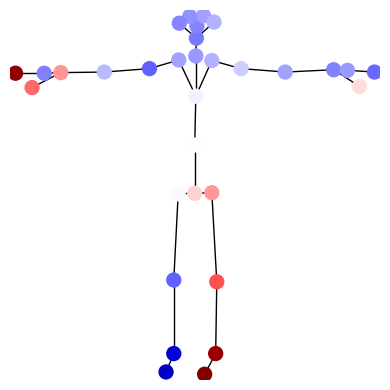

In [7]:
# Example setup
viz = Visualizer()

signal = gait.get_velocity_matrix('y')[:, 10]  # shape: (n_nodes,)

# Plot the signal
fig, ax = plt.subplots(figsize=(4, 4))

viz.plot_graph_signal(
    signal=signal,
    ax=ax,
    graph=skeleton,
    pos=pos
)

plt.tight_layout()
plt.show()

Plot the graph-energy through time for the $y$-axis velocity component:

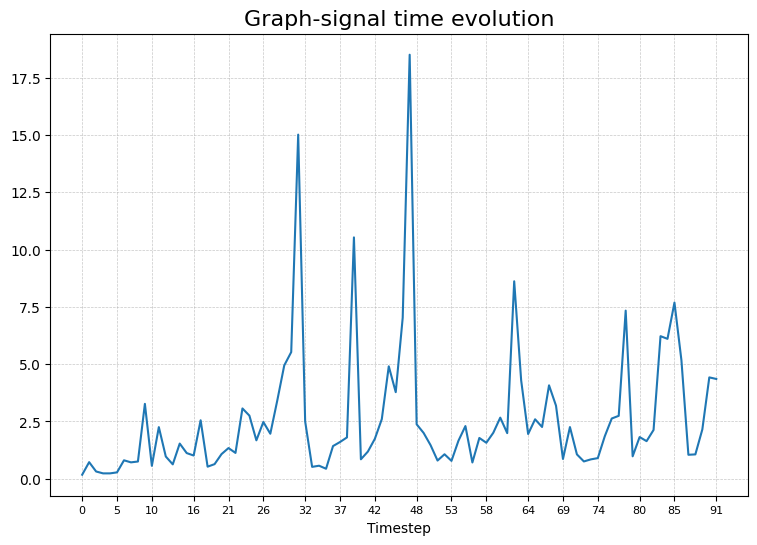

In [8]:
viz = Visualizer()
viz.plot_energy_evolution(gait.vy, display_timestamps=False)

Plot the graph-energy through time for all the velocity components:

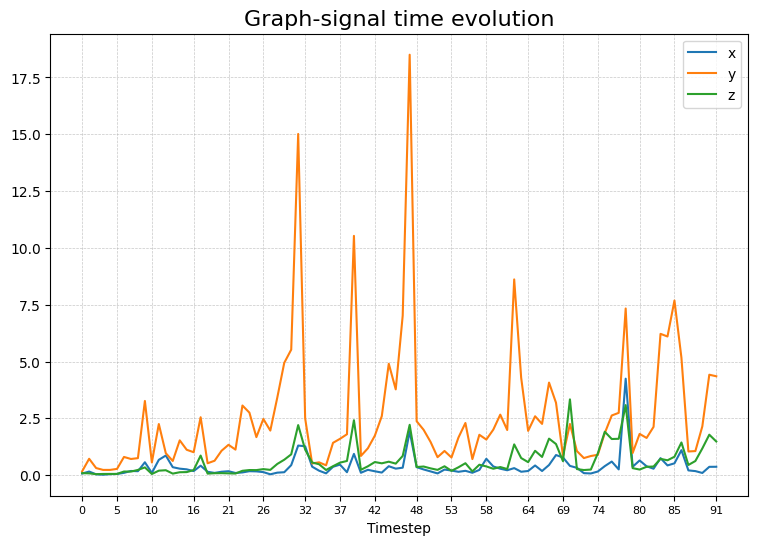

In [9]:
gaitviz = GaitVisualizer()
gaitviz.plot_energy_evolution_all_components(gait)

Gait animation (saved in `results` directory):

Processing Normal gait trial animation:
File saved at: ../results/walking_skeleton_normal_with_vectors.gif
  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92, 

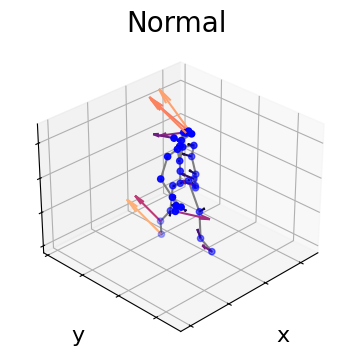

In [10]:
gaitviz = GaitVisualizer()
gaitviz.walking_skeleton_animation(gait)

Processing Normal gait trial animation:
File saved at: ../results/walking_skeleton_normal_without_vectors.gif
  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92, 

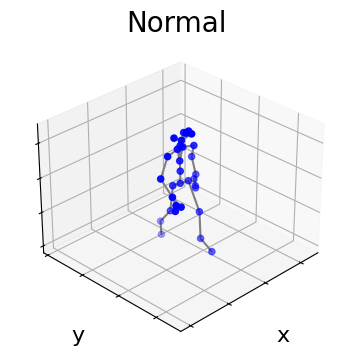

In [11]:
gaitviz.walking_skeleton_animation(gait, display_velocity_vectors=False)

# Comparing gait types

Animation grid for one instance of every gait type (saved in `results` directory):

In [12]:
fnames = [
    'subject12/normal/trial1/skeleton.csv',
    'subject10/trendelenburg/trial1/skeleton.csv',
    'subject10/steppage/trial1/skeleton.csv',
    'subject10/antalgic/trial10/skeleton.csv',
    'subject1/stiff-legged/trial11/skeleton.csv',
    'subject1/lurching/trial1/skeleton.csv'
]

gaits_dict = dict()
min_frames = np.inf

for fname in fnames:
    gait_label = fname.split('/')[1]
    r = preproc.load_and_process(fname)
    gait = GaitTrial(r, skeleton, label=gait_label)

    gaits_dict[gait_label] = gait
    min_frames = min([min_frames, r.shape[0]])

  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 
100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 
110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 
120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 
140, 141, 142, 143, 144, 145, 146,   0, 

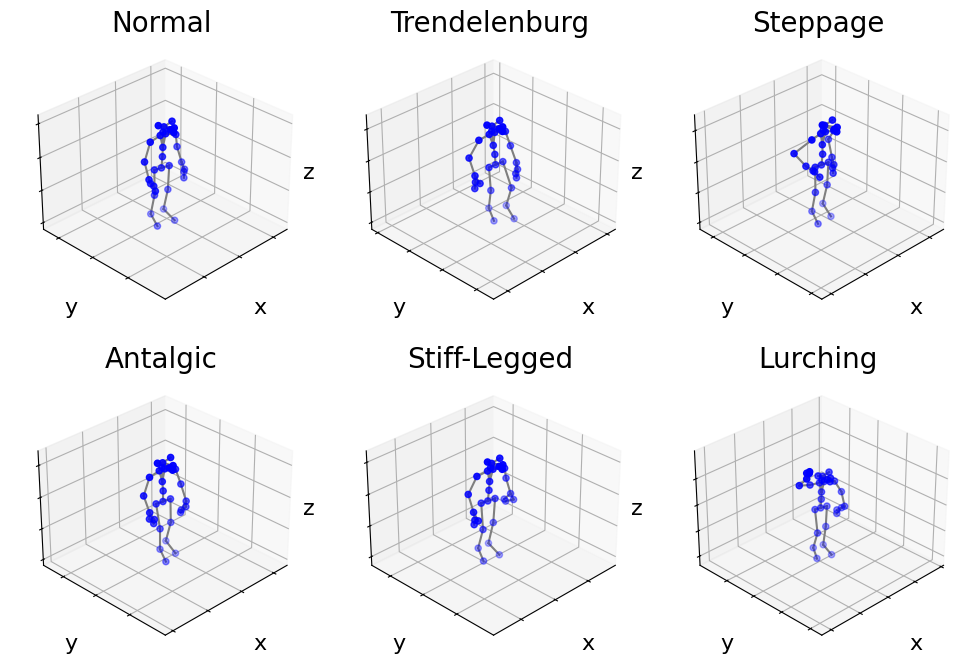

In [13]:
# Gait types animations grid

fig, axes = plt.subplots(2, 3, subplot_kw={'projection': '3d'}, figsize=(12, 8))
axes = axes.flatten()
[ax.view_init(elev=30, azim=45, roll=0) for ax in axes]

gaitviz = GaitVisualizer()

def update_grid(frame, gaits_dict):

    print(f"{frame:>3}", end=", " + ("\n" if ((frame+1)%10)==0 else ""))

    for ax, (label, gait) in zip(axes, gaits_dict.items()):
        gaitviz.update_skeleton_frame(frame, gait, ax, show_progress=False, display_velocity_vectors=False)

fps = 12  # frames per second
interval = 1000 / fps  # interval in milliseconds

ani = FuncAnimation(fig, update_grid, frames=min_frames,
                    interval=interval, repeat=False, fargs=(gaits_dict,))

ani.save(f"../results/3d_grid_animation.gif", writer="ffmpeg")

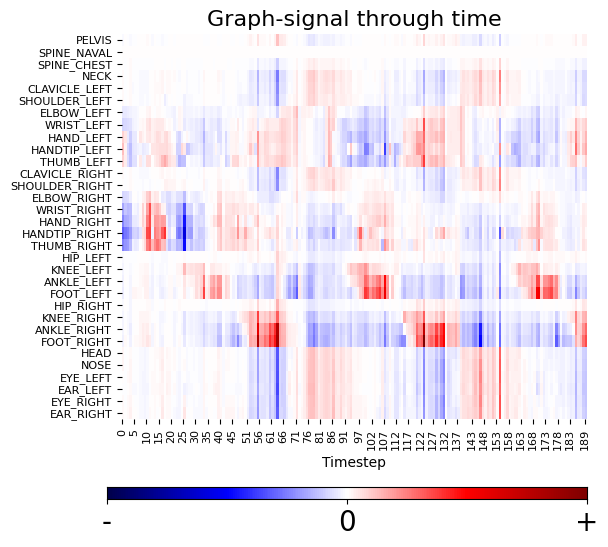

In [14]:
viz = Visualizer()
viz.plot_graph_signal_matrix(gait.vy)

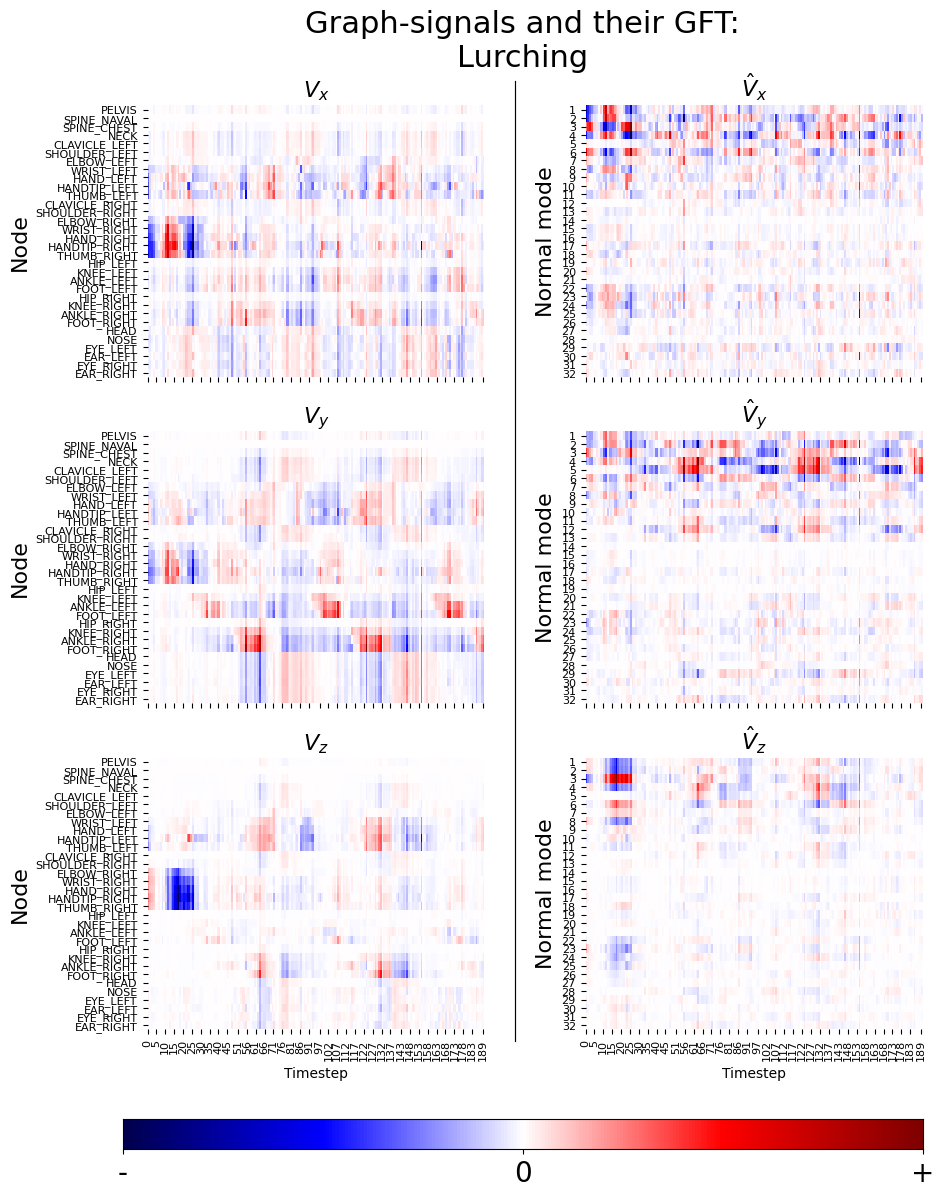

In [15]:
gaitviz = GaitVisualizer()
gaitviz.plot_original_signal_vs_gft(gait)

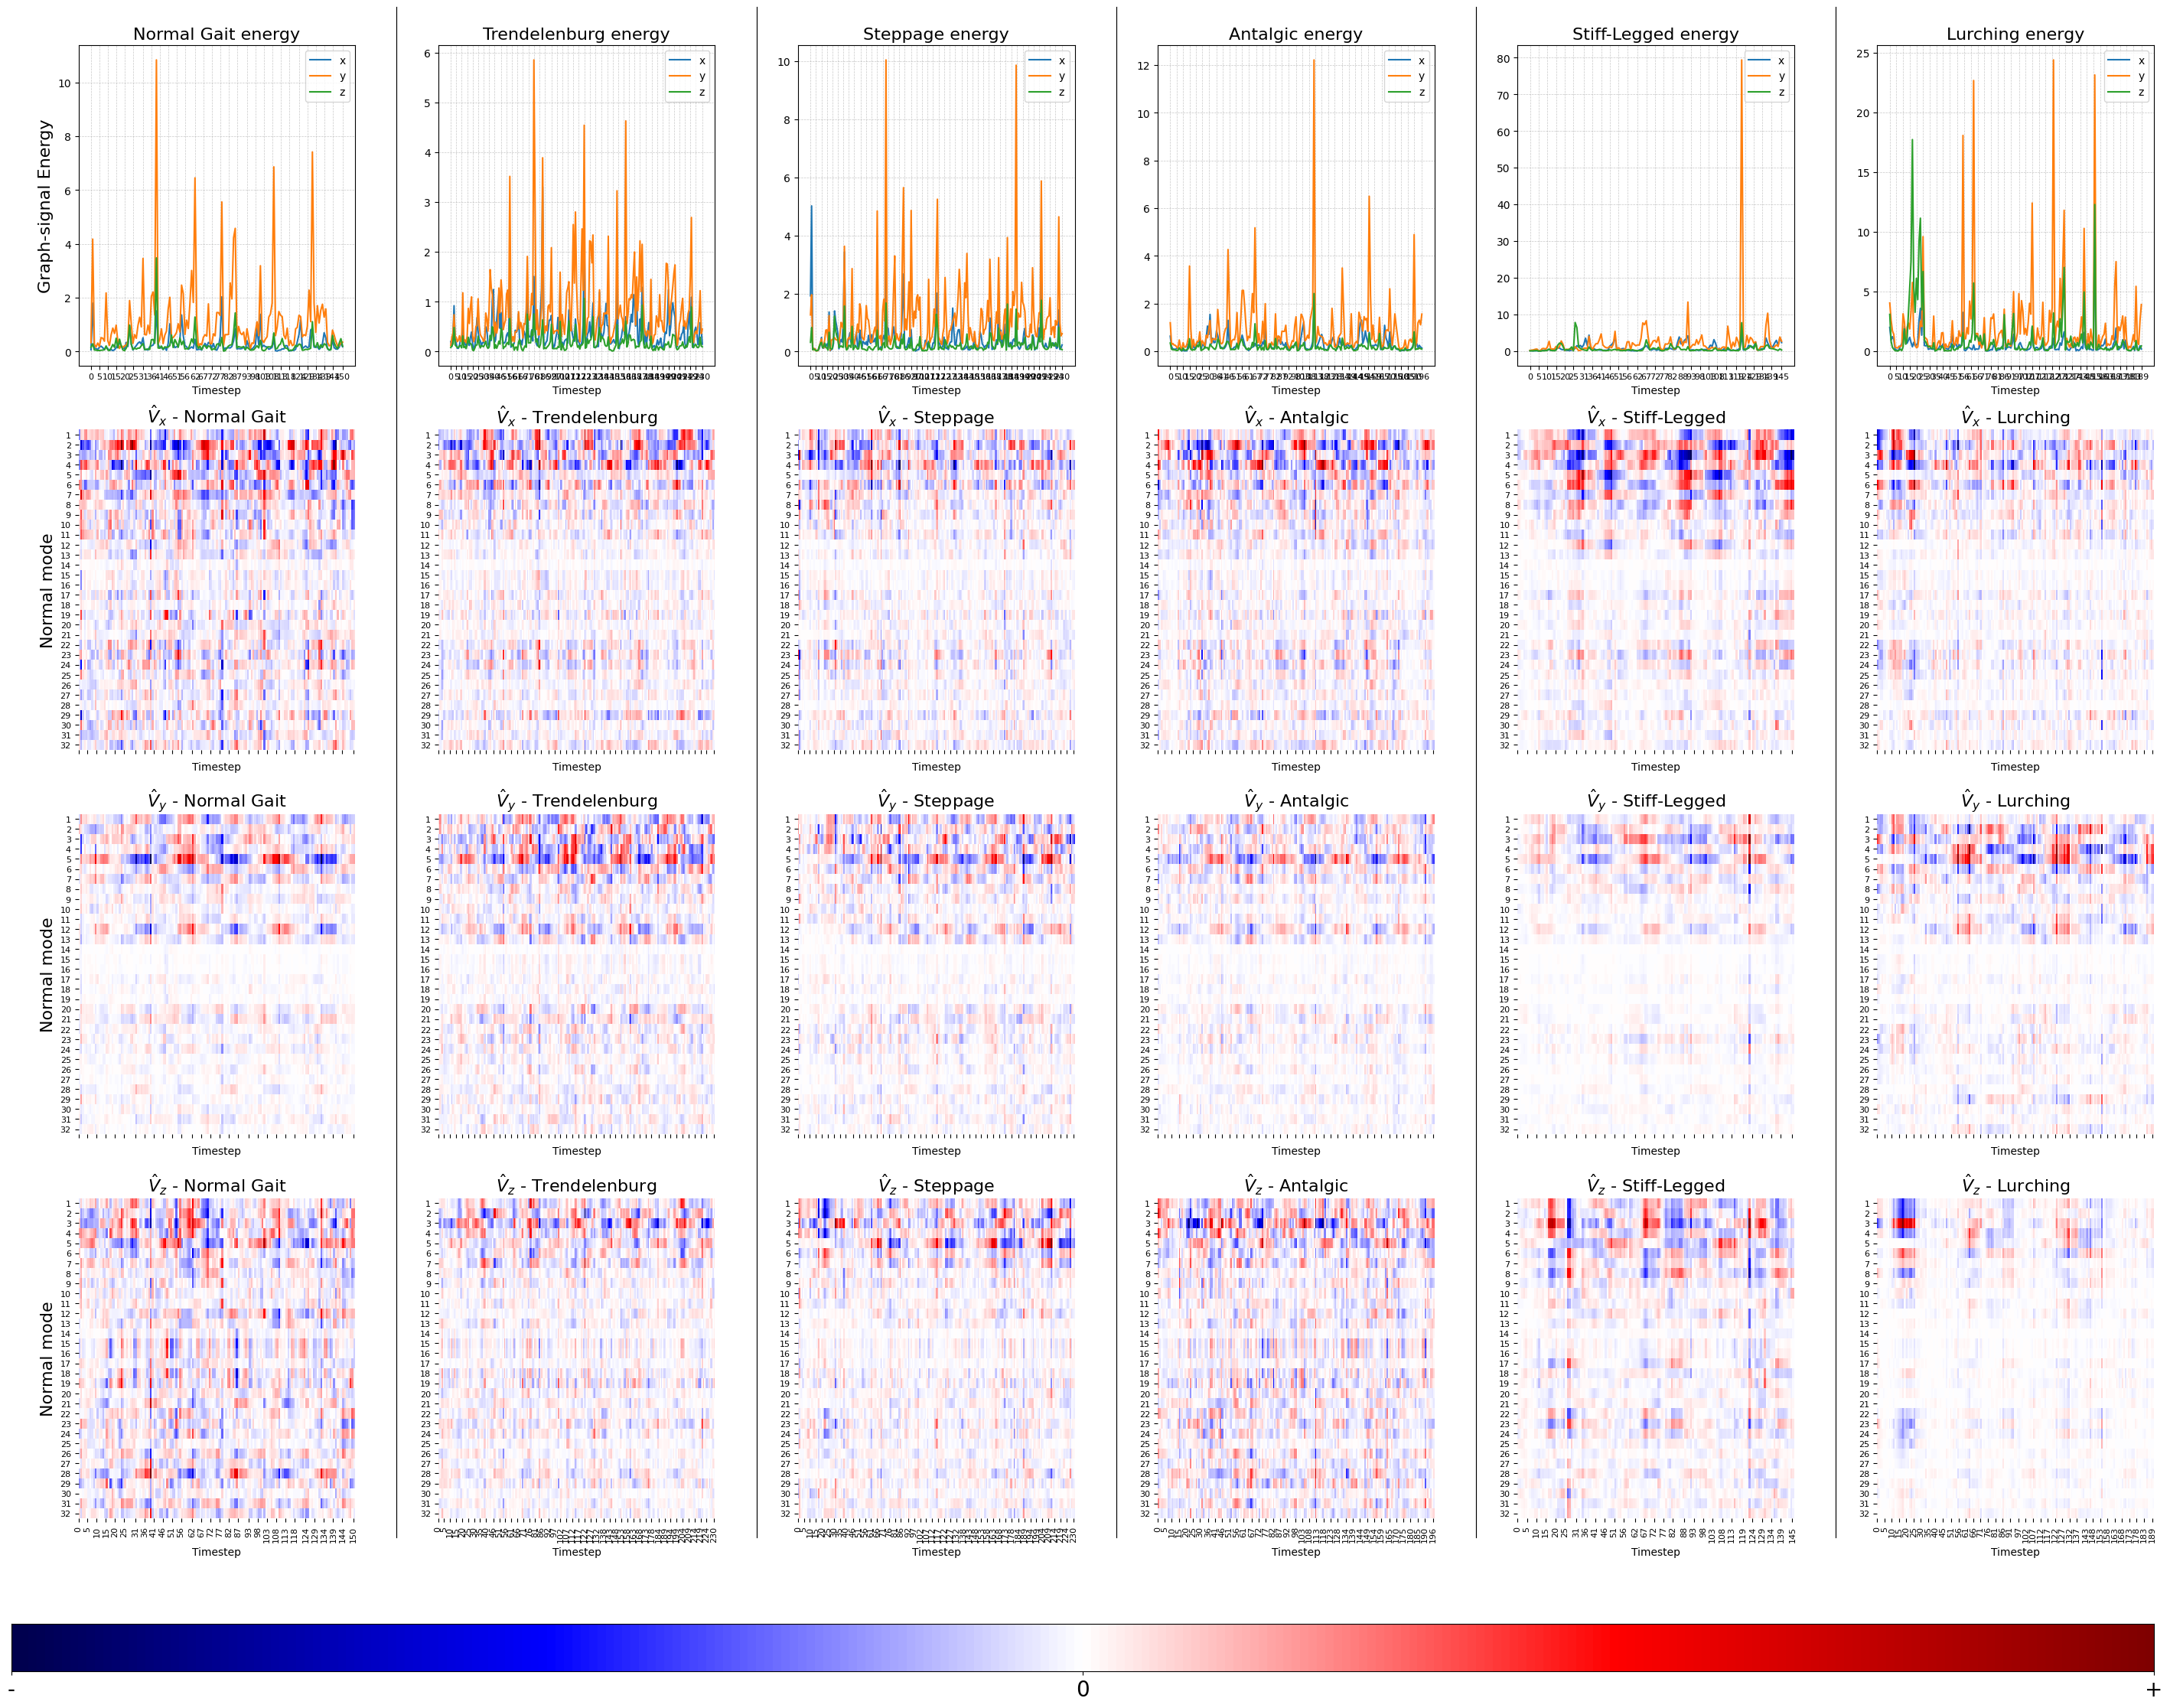

In [16]:
gaitviz.plot_compare_gait_types(gaits_dict)

File saved at: ../results/skeleton_gft_animation_vy.gif
  0,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9, 
 10,  11,  12,  13,  14,  15,  16,  17,  18,  19, 
 20,  21,  22,  23,  24,  25,  26,  27,  28,  29, 
 30,  31,  32,  33,  34,  35,  36,  37,  38,  39, 
 40,  41,  42,  43,  44,  45,  46,  47,  48,  49, 
 50,  51,  52,  53,  54,  55,  56,  57,  58,  59, 
 60,  61,  62,  63,  64,  65,  66,  67,  68,  69, 
 70,  71,  72,  73,  74,  75,  76,  77,  78,  79, 
 80,  81,  82,  83,  84,  85,  86,  87,  88,  89, 
 90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 
100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 
110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 
120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 
130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 
140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 
150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 
160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 
170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 
180, 181, 182, 183, 1

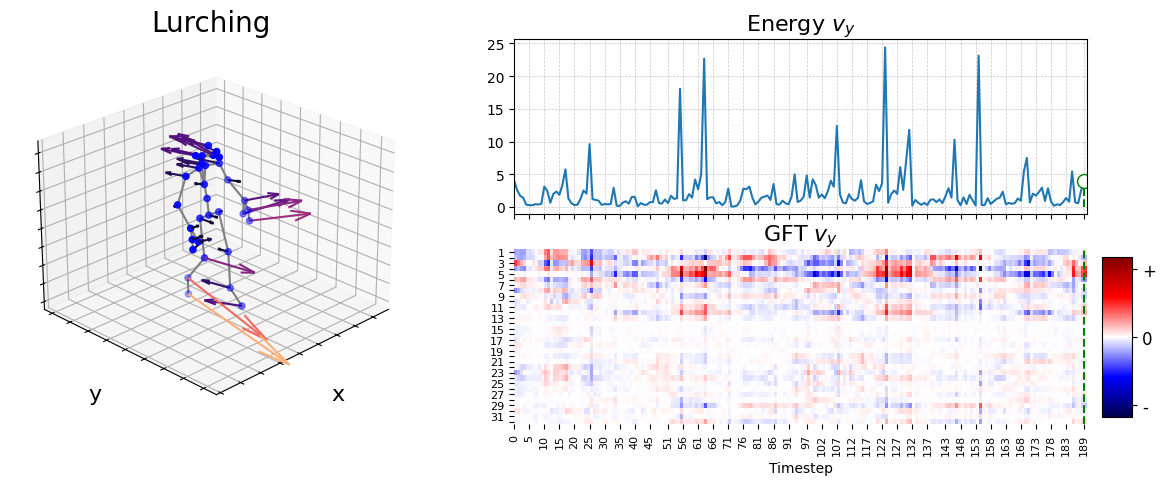

In [17]:
gaitviz = GaitVisualizer()
gaitviz.animation_with_gft_summary(skeleton, gait, gait.vy)

In [ ]:
# - Notebook coherente, mostrando resultados (que el lector interprete el código)

# Pendiente: README.md del github

In [18]:
# El objeto gait debe:

# -tener metodo de filtro, que guarde en filtered signal
# -usando el filtered signal, que sea capaz de recuperar las posiciones originales

# [ChatGPT]